In [1]:
from __future__ import print_function
#from hdfs import InsecureClient
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
#import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import keras
from keras import regularizers
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,PReLU, LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow as tf
#import horovod.keras as hvd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df = pd.read_excel('NEW TEG DATA_new.xlsx',)
df.drop(columns='sheet id',inplace=True)
df.dropna(inplace=True)

In [3]:
df['0650_RIE_CH']=df['0650_RIE_TOOLID']+'_'+df['0650_RIE_CHAMBER']
# drop 650 tool ch
df.drop(columns = df.columns[df.columns== '0650_RIE_TOOLID'], inplace=True)
df.drop(columns = df.columns[df.columns== '0650_RIE_CHAMBER'], inplace=True)

In [4]:
df['0200_CVD_CH']=df['0200_CVD_TOOLID']+'_'+df['0200_CVD_CHAMBER']
# drop 200 tool ch
df.drop(columns = df.columns[df.columns== '0200_CVD_TOOLID'], inplace=True)
df.drop(columns = df.columns[df.columns== '0200_CVD_CHAMBER'], inplace=True)

In [5]:
# df_CH=df[df['0200_CVD_TOOLID']=='VDN04B']
# df_CH=df_CH[df_CH['0200_CVD_CHAMBER']=='KPC_CHA']
# df_CH.head()

In [6]:
df_y = np.log1p(df['ioff_0v']*1e12)
df_y.head()

1    3.269854
2    3.062787
3    2.714778
4    3.053293
5    2.880649
Name: ioff_0v, dtype: float64

In [7]:
#df_1110_sheetid = df_1110["SHEET ID"]
df_x = df.iloc[:,5:]
df_x.head()

teg_eq  0650_RIE_0001_APCAV  0650_RIE_0001_APCMN  0650_RIE_0001_APCMX  \
1  TEG02B                   92                   90                   96   
2  TEG02B                   92                   90                   97   
3  TEG02B                   92                   77                   97   
4  TEG02B                   97                   90                  101   
5  TEG02B                   96                   89                   99   

   0650_RIE_0001_BISAV  0650_RIE_0001_BISMN  0650_RIE_0001_BISMX  \
1                 1931                 1291                 1971   
2                 1943                 1511                 1971   
3                 1920                 1120                 1971   
4                 1976                 1976                 1978   
5                 1938                 1301                 1986   

   0650_RIE_0001_BREAV  0650_RIE_0001_BREMN  0650_RIE_0001_BREMX  ...  \
1                    7                  0.0                   54  ...   
2                    6                  0.0                   47  ...   
3                    7                  0.0                   53  ...   
4                   11                  5.0                   14  ...   
5                    1                  0.0                   15  ...   

   0200_CVD_0006_S43  0200_CVD_0006_V11  0200_CVD_0006_V12  0200_CVD_0006_V13  \
1              778.0              169.4              154.5              164.9   
2              778.0              181.2              178.6              179.6   
3              778.0              161.7              148.0              158.3   
4              782.0              181.3              170.4              178.8   
5              778.0              175.5              163.4              171.3   

   0200_CVD_0006_V21  0200_CVD_0006_V22  0200_CVD_0006_V23  0200_CVD_0006_VAL  \
1              6.490              26.58              13.29                5.5   
2             11.980              18.60              16.00                6.0   
3              3.744              20.34              11.49                6.0   
4             10.110              24.09              21.43                6.0   
5              5.242              14.60              11.08                5.1   

   0650_RIE_CH     0200_CVD_CH  
1   DRT02B_CB3  VDN03B_KPC_CHC  
2   DRT02B_CB3  VDN03B_KPC_CHD  
3   DRT02B_CB3  VDN04B_KPC_CHE  
4   DRT02B_CB1  VDN04B_KPC_CHC  
5   DRT02B_CB2  VDN04B_KPC_CHA  

[5 rows x 493 columns]

In [8]:
df_x.isnull().sum()[df_x.columns[df_x.isnull().sum()>0]]

Series([], dtype: int64)

In [9]:
df_x.shape

(1026, 493)

In [10]:
# drop step4
df_x.drop(columns = df_x.columns[df_x.columns.str[5:13]== 'RIE_0004'], inplace=True)

In [11]:
# drop min kpc
df_x.drop(columns = df_x.columns[df_x.columns.str[17:19]== 'MN'], inplace=True)

In [12]:
# # drop max/min gas
for i in range(1,7):
    df_x.drop(columns = df_x.columns[df_x.columns.str[14:18]== 'GS'+str(i)+'M'], inplace=True)

In [13]:
df_chk_gas=df_x[df_x.columns[df_x.columns.str[13:16]== '_GS']].mean()
df_chk_gas.head()

0650_RIE_0001_GS1AV      0.029240
0650_RIE_0001_GS2AV      1.141326
0650_RIE_0001_GS3AV      1.952242
0650_RIE_0001_GS4AV    902.215400
0650_RIE_0001_GS5AV      0.129630
dtype: float64

In [14]:
gas=df_chk_gas[df_chk_gas < 30].index
gas

Index(['0650_RIE_0001_GS1AV', '0650_RIE_0001_GS2AV', '0650_RIE_0001_GS3AV',
       '0650_RIE_0001_GS5AV', '0650_RIE_0001_GS6AV', '0650_RIE_0002_GS2AV',
       '0650_RIE_0002_GS3AV', '0650_RIE_0002_GS4AV', '0650_RIE_0002_GS5AV',
       '0650_RIE_0002_GS6AV', '0650_RIE_0003_GS1AV', '0650_RIE_0003_GS4AV',
       '0650_RIE_0003_GS5AV', '0650_RIE_0003_GS6AV', '0650_RIE_0003_GS7AV',
       '0650_RIE_0003_GS7MX'],
      dtype='object')

In [15]:
# drop no use gas
for i in gas:
    df_x=df_x.drop(i, axis=1)

In [16]:
# mx=df_x.columns[df_x.columns.str[17:19]== 'MX']
# mx

In [17]:
# mx=mx[mx.str[14:16]!='VP']
# mx=mx[mx.str[14:16]!='BR']
# mx=mx[mx.str[14:16]!='EM']
# mx=mx[mx.str[14:16]!='HP']
# mx=mx[mx.str[14:16]!='VD']
# mx=mx[mx.str[14:16]!='FR']
# mx=mx[mx.str[14:16]!='BI']

In [18]:
# drop no use mx
# for i in mx:
#      df_x = df_x.drop(i, axis=1)

In [19]:
# drop no use columns
df_x.drop(columns = df_x.columns[df_x.columns.str[13:17]== '_EPD'], inplace=True)

In [20]:
df_x.iloc[:,2:95].head()

0650_RIE_0001_APCMX  0650_RIE_0001_BISAV  0650_RIE_0001_BISMX  \
1                   96                 1931                 1971   
2                   97                 1943                 1971   
3                   97                 1920                 1971   
4                  101                 1976                 1978   
5                   99                 1938                 1986   

   0650_RIE_0001_BREAV  0650_RIE_0001_BREMX  0650_RIE_0001_EMAAV  \
1                    7                   54                  0.0   
2                    6                   47                  0.0   
3                    7                   53                  0.0   
4                   11                   14                  0.0   
5                    1                   15                  0.0   

   0650_RIE_0001_EMAMX  0650_RIE_0001_ESCAV  0650_RIE_0001_ESCMX  \
1                  0.0               1903.0               1998.0   
2                  0.0               1910.0               1999.0   
3                  0.0               1896.0               1999.0   
4                  0.1               1899.0               1999.0   
5                  0.1               1911.0               2005.0   

   0650_RIE_0001_GS4AV  ...  0650_RIE_0002_VPLAV  0650_RIE_0002_VPLMX  \
1                  899  ...                665.0                685.0   
2                  899  ...                665.0                685.0   
3                  899  ...                660.0                685.0   
4                  899  ...                782.0                815.0   
5                  900  ...                835.0                877.0   

   0650_RIE_0002_VPUAV  0650_RIE_0002_VPUMX  0650_RIE_0003_APCAV  \
1               3630.0               3676.0                111.0   
2               3626.0               3676.0                112.0   
3               3610.0               3663.0                114.0   
4               3506.0               3553.0                117.0   
5               3526.0               3570.0                111.0   

   0650_RIE_0003_APCMX  0650_RIE_0003_BISAV  0650_RIE_0003_BISMX  \
1                115.0                968.0                970.0   
2                115.0                968.0                970.0   
3                116.0                968.0                970.0   
4                120.0                973.0                975.0   
5                117.0                971.0                973.0   

   0650_RIE_0003_BREAV  0650_RIE_0003_BREMX  
1                  9.0                 27.0  
2                  9.0                 24.0  
3                  9.0                 30.0  
4                  0.0                  3.0  
5                  2.0                 23.0  

[5 rows x 93 columns]

In [21]:
df_x.iloc[:,2:95].describe()

0650_RIE_0001_APCMX  0650_RIE_0001_BISAV  0650_RIE_0001_BISMX  \
count          1026.000000          1026.000000          1026.000000   
mean             98.593567          1967.169591          1987.813840   
std               4.500788            33.814768             9.444546   
min              90.000000          1880.000000          1971.000000   
25%              97.000000          1938.000000          1978.000000   
50%              98.000000          1988.000000          1991.000000   
75%             101.000000          1993.000000          1996.000000   
max             118.000000          1996.000000          2033.000000   

       0650_RIE_0001_BREAV  0650_RIE_0001_BREMX  0650_RIE_0001_EMAAV  \
count          1026.000000          1026.000000          1026.000000   
mean              7.227096            28.860624             0.013743   
std               8.820712            27.149434             0.034447   
min               0.000000             0.000000             0.000000   
25%               1.000000            10.000000             0.000000   
50%               7.000000            17.000000             0.000000   
75%              12.750000            37.000000             0.000000   
max             236.000000           305.000000             0.100000   

       0650_RIE_0001_EMAMX  0650_RIE_0001_ESCAV  0650_RIE_0001_ESCMX  \
count          1026.000000          1026.000000          1026.000000   
mean              0.083723          1869.735867          1985.823587   
std               0.064302            46.160625            32.736719   
min               0.000000          1660.000000          1901.000000   
25%               0.000000          1818.000000          1979.000000   
50%               0.100000          1898.000000          1998.000000   
75%               0.100000          1908.000000          2005.000000   
max               0.200000          1931.000000          2011.000000   

       0650_RIE_0001_GS4AV  ...  0650_RIE_0002_VPLAV  0650_RIE_0002_VPLMX  \
count          1026.000000  ...          1026.000000          1026.000000   
mean            902.215400  ...           943.279727           984.635478   
std               4.684317  ...           241.995543           253.791283   
min             898.000000  ...           632.000000           645.000000   
25%             899.000000  ...           765.000000           790.000000   
50%             900.000000  ...           817.000000           862.000000   
75%             906.000000  ...          1210.000000          1240.000000   
max             913.000000  ...          1357.000000          1457.000000   

       0650_RIE_0002_VPUAV  0650_RIE_0002_VPUMX  0650_RIE_0003_APCAV  \
count          1026.000000          1026.000000          1026.000000   
mean           3546.951267          3595.276803           111.385965   
std              64.236526            72.237126             3.844941   
min            3413.000000          3459.000000            86.000000   
25%            3510.000000          3553.000000           110.000000   
50%            3536.000000          3580.000000           111.000000   
75%            3613.000000          3663.000000           114.000000   
max            3656.000000          3733.000000           127.000000   

       0650_RIE_0003_APCMX  0650_RIE_0003_BISAV  0650_RIE_0003_BISMX  \
count          1026.000000          1026.000000          1026.000000   
mean            115.003899           973.198830           979.406433   
std               4.584383            14.299972             7.359846   
min              92.000000           916.000000           963.000000   
25%             113.000000           971.000000           973.000000   
50%             116.000000           980.000000           980.000000   
75%             118.000000           981.000000           981.000000   
max             137.000000           995.000000          1058.000000   

       0650_RIE_0003_BREAV  0650_RIE_0003_BREMX  
count          102

In [22]:
# df_x = pd.get_dummies(df_x)

In [23]:
df_x.columns

Index(['teg_eq', '0650_RIE_0001_APCAV', '0650_RIE_0001_APCMX',
       '0650_RIE_0001_BISAV', '0650_RIE_0001_BISMX', '0650_RIE_0001_BREAV',
       '0650_RIE_0001_BREMX', '0650_RIE_0001_EMAAV', '0650_RIE_0001_EMAMX',
       '0650_RIE_0001_ESCAV',
       ...
       '0200_CVD_0006_S43', '0200_CVD_0006_V11', '0200_CVD_0006_V12',
       '0200_CVD_0006_V13', '0200_CVD_0006_V21', '0200_CVD_0006_V22',
       '0200_CVD_0006_V23', '0200_CVD_0006_VAL', '0650_RIE_CH', '0200_CVD_CH'],
      dtype='object', length=288)

In [24]:
teg = df_x['teg_eq'].unique().tolist()
RIE = df_x['0650_RIE_CH'].unique().tolist()
CVD = df_x['0200_CVD_CH'].unique().tolist()
print(teg)
print(RIE)
print(CVD)

['TEG02B', 'TEG01B']
['DRT02B_CB3', 'DRT02B_CB1', 'DRT02B_CB2', 'DRT01B_CB1', 'DRT01B_CB3', 'DRT01B_CB2', 'DRT03B_CB3', 'DRT03B_CB1', 'DRT03B_CB2']
['VDN03B_KPC_CHC', 'VDN03B_KPC_CHD', 'VDN04B_KPC_CHE', 'VDN04B_KPC_CHC', 'VDN04B_KPC_CHA', 'VDN04B_KPC_CHB', 'VDN02B_KPC_CHC', 'VDN02B_KPC_CHA', 'VDN03B_KPC_CHB', 'VDN03B_KPC_CHE', 'VDN03B_KPC_CHA', 'VDN06B_KPC_CHC', 'VDN06B_KPC_CHE', 'VDN06B_KPC_CHB', 'VDN06B_KPC_CHD', 'VDN06B_KPC_CHA', 'VDN02B_KPC_CHE', 'VDN07B_KPC_CHB', 'VDN07B_KPC_CHE', 'VDN07B_KPC_CHD', 'VDN07B_KPC_CHA', 'VDN07B_KPC_CHC', 'VDN04B_KPC_CHD', 'VDN02B_KPC_CHB']


In [25]:
# generate teg feature encoder
teg_label = LabelEncoder()
teg_label.fit(teg)
df_x['teg_eq'] = teg_label.transform(df_x['teg_eq'])

In [26]:
# generate RIE feature encoder
RIE_label = LabelEncoder()
RIE_label.fit(RIE)
df_x['0650_RIE_CH'] = RIE_label.transform(df_x['0650_RIE_CH'])

In [27]:
# generate CVD feature encoder
CVD_label = LabelEncoder()
CVD_label.fit(CVD)
df_x['0200_CVD_CH'] = CVD_label.transform(df_x['0200_CVD_CH'])

In [28]:
df_y.name

'ioff_0v'

In [29]:
df_x.head()

teg_eq  0650_RIE_0001_APCAV  0650_RIE_0001_APCMX  0650_RIE_0001_BISAV  \
1       1                   92                   96                 1931   
2       1                   92                   97                 1943   
3       1                   92                   97                 1920   
4       1                   97                  101                 1976   
5       1                   96                   99                 1938   

   0650_RIE_0001_BISMX  0650_RIE_0001_BREAV  0650_RIE_0001_BREMX  \
1                 1971                    7                   54   
2                 1971                    6                   47   
3                 1971                    7                   53   
4                 1978                   11                   14   
5                 1986                    1                   15   

   0650_RIE_0001_EMAAV  0650_RIE_0001_EMAMX  0650_RIE_0001_ESCAV  ...  \
1                  0.0                  0.0               1903.0  ...   
2                  0.0                  0.0               1910.0  ...   
3                  0.0                  0.0               1896.0  ...   
4                  0.0                  0.1               1899.0  ...   
5                  0.0                  0.1               1911.0  ...   

   0200_CVD_0006_S43  0200_CVD_0006_V11  0200_CVD_0006_V12  0200_CVD_0006_V13  \
1              778.0              169.4              154.5              164.9   
2              778.0              181.2              178.6              179.6   
3              778.0              161.7              148.0              158.3   
4              782.0              181.3              170.4              178.8   
5              778.0              175.5              163.4              171.3   

   0200_CVD_0006_V21  0200_CVD_0006_V22  0200_CVD_0006_V23  0200_CVD_0006_VAL  \
1              6.490              26.58              13.29                5.5   
2             11.980              18.60              16.00                6.0   
3              3.744              20.34              11.49                6.0   
4             10.110              24.09              21.43                6.0   
5              5.242              14.60              11.08                5.1   

   0650_RIE_CH  0200_CVD_CH  
1            5            6  
2            5            7  
3            5           13  
4            3           11  
5            4            9  

[5 rows x 288 columns]

In [30]:
#Z-Score標準化
#建立StandardScaler物件
zscore = preprocessing.StandardScaler()
# 標準化處理
#x = zscore.fit_transform(x)
df_x.iloc[:,1:-2] = zscore.fit_transform(df_x.iloc[:,1:-2])

In [31]:
df_x.shape

(1026, 288)

In [32]:
df_y.shape

(1026,)

In [33]:
df_encorder = df_x.copy()

In [34]:
df_encorder['ioff_0v']=df_y

In [35]:
df_encorder. shape

(1026, 289)

In [36]:
df_encorder.head()

teg_eq  0650_RIE_0001_APCAV  0650_RIE_0001_APCMX  0650_RIE_0001_BISAV  \
1       1            -0.759113            -0.576528            -1.070161   
2       1            -0.759113            -0.354237            -0.715113   
3       1            -0.759113            -0.354237            -1.395621   
4       1             0.465494             0.534930             0.261268   
5       1             0.220572             0.090347            -0.863049   

   0650_RIE_0001_BISMX  0650_RIE_0001_BREAV  0650_RIE_0001_BREMX  \
1            -1.781138            -0.025758             0.926415   
2            -1.781138            -0.139183             0.668457   
3            -1.781138            -0.025758             0.889564   
4            -1.039608             0.427941            -0.547631   
5            -0.192145            -0.706307            -0.510780   

   0650_RIE_0001_EMAAV  0650_RIE_0001_EMAMX  0650_RIE_0001_ESCAV  ...  \
1            -0.399152            -1.302657             0.720968  ...   
2            -0.399152            -1.302657             0.872687  ...   
3            -0.399152            -1.302657             0.569250  ...   
4            -0.399152             0.253252             0.634272  ...   
5            -0.399152             0.253252             0.894361  ...   

   0200_CVD_0006_V11  0200_CVD_0006_V12  0200_CVD_0006_V13  0200_CVD_0006_V21  \
1          -0.310070          -0.574527          -0.253071          -0.621879   
2           0.915791           1.645697           1.127650           0.889765   
3          -1.109996          -1.173343          -0.872986          -1.377976   
4           0.926180           0.890268           1.052509           0.374870   
5           0.323638           0.245390           0.348059          -0.965509   

   0200_CVD_0006_V22  0200_CVD_0006_V23  0200_CVD_0006_VAL  0650_RIE_CH  \
1           0.428409          -0.799745          -0.611978            5   
2          -0.759905          -0.272433           0.633835            5   
3          -0.500799          -1.149988           0.633835            5   
4           0.057619           0.784135           0.633835            3   
5          -1.355551          -1.229766          -1.608629            4   

   0200_CVD_CH   ioff_0v  
1            6  3.269854  
2            7  3.062787  
3           13  2.714778  
4           11  3.053293  
5            9  2.880649  

[5 rows x 289 columns]

In [37]:
fake_df, test_df = train_test_split(df_encorder,random_state=0,
                                                    test_size=0.2)

In [38]:
import numpy as np
np.random.seed(0)  # for reproducibility
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

In [39]:
# in order to plot in a 2D figure
latent_dim = 26

# this is our input placeholder
encoder_input = Input(shape=(289,), name='encoder_input')

decoder_input = Input(shape=(latent_dim,), name='z_sampling')

In [40]:
# encoder layers
encoded = Dense(224, activation='relu')(encoder_input)
encoded = Dense(112, activation='relu')(encoded)
encoded = Dense(56, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='tanh')(encoded)

In [41]:
# instantiate encoder model
encoder = Model(encoder_input, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 289)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 224)               64960     
_________________________________________________________________
dense_2 (Dense)              (None, 112)               25200     
_________________________________________________________________
dense_3 (Dense)              (None, 56)                6328      
_________________________________________________________________
dense_4 (Dense)              (None, 26)                1482      
Total params: 97,970
Trainable params: 97,970
Non-trainable params: 0
_________________________________________________________________


In [42]:
# decoder layers
decoded = Dense(56, activation='relu')(decoder_input)
decoded = Dense(112, activation='relu')(decoded)
decoded = Dense(224, activation='relu')(decoded)
decoded = Dense(289, activation='tanh')(decoded)

In [43]:
# instantiate decoder model
decoder = Model(decoder_input, decoded, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 26)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 56)                1512      
_________________________________________________________________
dense_6 (Dense)              (None, 112)               6384      
_________________________________________________________________
dense_7 (Dense)              (None, 224)               25312     
_________________________________________________________________
dense_8 (Dense)              (None, 289)               65025     
Total params: 98,233
Trainable params: 98,233
Non-trainable params: 0
_________________________________________________________________


In [44]:
AE_output = decoder(encoder(encoder_input))

In [45]:
# construct the autoencoder model
AE = Model(input=encoder_input, output=AE_output)
AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 289)               0         
_________________________________________________________________
encoder (Model)              (None, 26)                97970     
_________________________________________________________________
decoder (Model)              (None, 289)               98233     
Total params: 196,203
Trainable params: 196,203
Non-trainable params: 0
_________________________________________________________________


In [46]:
# compile autoencoder
AE.compile(optimizer='adadelta', loss='mean_squared_error')

In [47]:
en_train, en_test, = train_test_split(fake_df,random_state=0,
                                                    test_size=0.2)

In [48]:
# training
model = AE.fit(en_train, en_train,
                epochs=700,
                batch_size=256,
                shuffle=True,
                validation_data=(en_test, en_test))


Train on 656 samples, validate on 164 samples
Epoch 1/700
656/656 [==============================] - 1s 825us/step - loss: 1.3946 - val_loss: 1.2991
Epoch 2/700
656/656 [==============================] - 0s 26us/step - loss: 1.3725 - val_loss: 1.2783
Epoch 3/700
656/656 [==============================] - 0s 24us/step - loss: 1.3473 - val_loss: 1.2578
Epoch 4/700
656/656 [==============================] - 0s 24us/step - loss: 1.3250 - val_loss: 1.2416
Epoch 5/700
656/656 [==============================] - 0s 24us/step - loss: 1.3061 - val_loss: 1.2269
Epoch 6/700
656/656 [==============================] - 0s 24us/step - loss: 1.2881 - val_loss: 1.2102
Epoch 7/700
656/656 [==============================] - 0s 26us/step - loss: 1.2677 - val_loss: 1.1951
Epoch 8/700
656/656 [==============================] - 0s 24us/step - loss: 1.2506 - val_loss: 1.1821
Epoch 9/700
656/656 [==============================] - 0s 25us/step - loss: 1.2342 - val_loss: 1.1682
Epoch 10/700
656/656 [=============

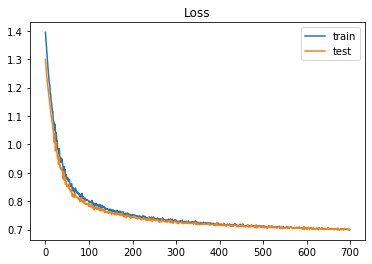

In [49]:
# plot loss during training
pyplot.title('Loss')
pyplot.plot(model.history['loss'], label='train')
pyplot.plot(model.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
encoded_imgs = encoder.predict(fake_df)

In [51]:
encoded_imgs = pd.DataFrame(encoded_imgs)

In [52]:
encoded_imgs.describe()

0           1           2           3           4           5   \
count  820.000000  820.000000  820.000000  820.000000  820.000000  820.000000   
mean    -0.552304    0.741904   -0.444383   -0.221156    2.070567    0.735924   
std      2.407658    2.690868    2.891934    2.424336    3.024694    2.208054   
min     -6.315825   -6.211220  -13.791431   -6.839662  -11.071913   -5.578692   
25%     -2.131759   -1.117640   -2.083496   -1.917040   -0.021276   -0.692246   
50%     -0.521210    0.649480   -0.406673   -0.116883    2.081129    0.611384   
75%      1.066180    2.360568    1.355726    1.537403    4.007532    1.929692   
max     14.439094   12.329694   33.353481    9.135983   26.173214   12.705199   

               6           7           8           9   ...          16  \
count  820.000000  820.000000  820.000000  820.000000  ...  820.000000   
mean    -0.346477    0.480302    0.498826    0.998737  ...    0.074802   
std      2.532909    2.910983    2.419142    2.900128  ...    2.046041   
min     -6.120764  -11.968708   -7.624356   -7.199309  ...  -13.120184   
25%     -2.128616   -1.282157   -1.194576   -0.909454  ...   -1.113994   
50%     -0.545325    0.445173    0.590608    0.969376  ...    0.182654   
75%      1.363069    2.245580    2.118764    2.662963  ...    1.313421   
max      7.616393   22.848804    7.918869   30.573589  ...   10.032612   

               17          18          19          20          21          22  \
count  820.000000  820.000000  820.000000  820.000000  820.000000  820.000000   
mean    -0.904002    0.227682   -0.481769    1.558971    0.935568    2.396811   
std      2.103416    2.347352    2.482337    1.892254    2.637342    2.575306   
min    -13.269566   -6.105719   -9.934407  -13.355019   -7.070464   -4.354094   
25%     -2.234598   -1.594293   -1.963749    0.492324   -0.650695    0.832511   
50%     -1.042072    0.242492   -0.155262    1.696392    0.944936    2.197307   
75%      0.353568    1.834211    0.982127    2.737178    2.534173    3.912964   
max      5.982772    7.134482    9.103883    6.800703   21.742929   14.216209   

               23          24          25  
count  820.000000  820.000000  820.000000  
mean     0.415937    0.497847    1.179026  
std      3.151698    2.746500    2.223684  
min     -8.459719   -9.349323   -5.226787  
25%     -1.737686   -1.465582   -0.459951  
50%      0.661683    0.388105    1.091514  
75%      2.611406    2.417569    2.741787  
max      9.033102   11.366761    9.011812  

[8 rows x 26 columns]

In [53]:
import random

In [54]:
A=[]
B=[]
C=[]
D=[]
E=[]
F=[]
G=[]
H=[]
I=[]
J=[]
K=[]
L=[]
M=[]
N=[]
O=[]
P=[]
Q=[]
R=[]
S=[]
T=[]
U=[]
V=[]
W=[]
X=[]
Y=[]

In [87]:
for i in range(500):
    A.append(random.uniform(encoded_imgs[0].min(),encoded_imgs[0].max()))
    B.append(random.uniform(encoded_imgs[1].min(),encoded_imgs[1].max()))
    C.append(random.uniform(encoded_imgs[2].min(),encoded_imgs[2].max()))
    D.append(random.uniform(encoded_imgs[3].min(),encoded_imgs[3].max()))
    E.append(random.uniform(encoded_imgs[4].min(),encoded_imgs[4].max()))
    F.append(random.uniform(encoded_imgs[5].min(),encoded_imgs[5].max()))
    G.append(random.uniform(encoded_imgs[6].min(),encoded_imgs[6].max()))
    H.append(random.uniform(encoded_imgs[7].min(),encoded_imgs[7].max()))
    I.append(random.uniform(encoded_imgs[8].min(),encoded_imgs[8].max()))
    J.append(random.uniform(encoded_imgs[9].min(),encoded_imgs[9].max()))
    K.append(random.uniform(encoded_imgs[10].min(),encoded_imgs[10].max()))
    L.append(random.uniform(encoded_imgs[11].min(),encoded_imgs[11].max()))
    M.append(random.uniform(encoded_imgs[12].min(),encoded_imgs[12].max()))
    N.append(random.uniform(encoded_imgs[13].min(),encoded_imgs[13].max()))
    O.append(random.uniform(encoded_imgs[14].min(),encoded_imgs[14].max()))
    P.append(random.uniform(encoded_imgs[15].min(),encoded_imgs[15].max()))
    Q.append(random.uniform(encoded_imgs[16].min(),encoded_imgs[16].max()))
    R.append(random.uniform(encoded_imgs[17].min(),encoded_imgs[17].max()))
    S.append(random.uniform(encoded_imgs[18].min(),encoded_imgs[18].max()))
    T.append(random.uniform(encoded_imgs[19].min(),encoded_imgs[19].max()))
    U.append(random.uniform(encoded_imgs[20].min(),encoded_imgs[20].max()))
    V.append(random.uniform(encoded_imgs[21].min(),encoded_imgs[21].max()))
    W.append(random.uniform(encoded_imgs[22].min(),encoded_imgs[22].max()))
    X.append(random.uniform(encoded_imgs[23].min(),encoded_imgs[23].max()))
    Y.append(random.uniform(encoded_imgs[24].min(),encoded_imgs[14].max()))


In [88]:
pp=pd.DataFrame([A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y]).T

In [89]:
fak_data = decoder.predict(encoded_imgs)

In [90]:
docoder_data = pd.DataFrame(fak_data,columns=list(fake_df))

In [91]:
fake_df.describe()

teg_eq  0650_RIE_0001_APCAV  0650_RIE_0001_APCMX  \
count  820.000000           820.000000           820.000000   
mean     0.473171            -0.028829            -0.019444   
std      0.499584             0.985972             0.996633   
min      0.000000            -2.228641            -1.910279   
25%      0.000000            -0.514192            -0.354237   
50%      0.000000            -0.024349            -0.131945   
75%      1.000000             0.465494             0.534930   
max      1.000000             2.669786             4.313889   

       0650_RIE_0001_BISAV  0650_RIE_0001_BISMX  0650_RIE_0001_BREAV  \
count           820.000000           820.000000           820.000000   
mean              0.007936             0.003314             0.021410   
std               1.005079             0.997518             1.079956   
min              -2.579113            -1.781138            -0.819732   
25%              -0.863049            -1.039608            -0.706307   
50%               0.675490             0.337519            -0.025758   
75%               0.764252             0.867183             0.654791   
max               0.853014             4.786699            25.948525   

       0650_RIE_0001_BREMX  0650_RIE_0001_EMAAV  0650_RIE_0001_EMAMX  \
count           820.000000           820.000000           820.000000   
mean             -0.005380             0.015266             0.036943   
std               1.002460             1.016454             0.990855   
min              -1.063547            -0.399152            -1.302657   
25%              -0.658184            -0.399152            -1.302657   
50%              -0.437078            -0.399152             0.253252   
75%               0.299945            -0.399152             0.253252   
max              10.176052             2.505314             1.809161   

       0650_RIE_0001_ESCAV  ...  0200_CVD_0006_V11  0200_CVD_0006_V12  \
count           820.000000  ...         820.000000         820.000000   
mean             -0.022769  ...           0.023431           0.018963   
std               1.008538  ...           0.987322           1.006372   
min              -4.545826  ...          -2.626740          -1.956409   
25%              -1.126744  ...          -0.746393          -1.035155   
50%               0.612598  ...           0.250917           0.199327   
75%               0.829339  ...           0.811905           0.754383   
max               1.327842  ...           2.027377           2.060262   

       0200_CVD_0006_V13  0200_CVD_0006_V21  0200_CVD_0006_V22  \
count         820.000000         820.000000         820.000000   
mean            0.012650          -0.011356          -0.035481   
std             0.993988           0.993950           0.998923   
min            -2.065854          -2.271470          -2.386763   
25%            -0.797845          -0.828112          -0.871589   
50%             0.244740          -0.209687           0.057619   
75%             0.845870           0.683256           0.669646   
max             1.766351           3.637707           2.435736   

       0200_CVD_0006_V23  0200_CVD_0006_VAL  0650_RIE_CH  0200_CVD_CH  \
count         820.000000         820.000000   820.000000   820.000000   
mean           -0.024291          -0.002745     3.675610     8.006098   
std             0.995459           1.009743     2.603115     5.026058   
min            -2.191379          -3.851092     0.000000     0.000000   
25%            -0.885360          -0.861141     1.000000     5.000000   
50%            -0.253948           0.633835     3.000000     9.000000   
75%             0.930556           0.633835     6.000000    11.000000   
max             2.017771           2.128810     8.000000    23.000000   

          ioff_0v  
count  820.000000  
mean     2.772159  
std      0.543675  
min      1.321600  
25%      2.398332  
50%      2.787344  
75%      3.123453  
max      4.846285  

[8 rows x 289 columns]

In [92]:
docoder_data.describe()

teg_eq  0650_RIE_0001_APCAV  0650_RIE_0001_APCMX  \
count  820.000000           820.000000           820.000000   
mean     0.513999            -0.063525            -0.053074   
std      0.180845             0.638312             0.623357   
min     -0.057796            -0.999884            -0.999935   
25%      0.386469            -0.561035            -0.486271   
50%      0.515168            -0.140701            -0.123693   
75%      0.642025             0.486076             0.481393   
max      0.975064             0.999508             0.999014   

       0650_RIE_0001_BISAV  0650_RIE_0001_BISMX  0650_RIE_0001_BREAV  \
count           820.000000           820.000000           820.000000   
mean              0.178469             0.116141             0.062785   
std               0.788904             0.765989             0.583635   
min              -1.000000            -0.999999            -0.974091   
25%              -0.811996            -0.858189            -0.445890   
50%               0.667101             0.366456             0.076809   
75%               0.821289             0.857636             0.653571   
max               0.999857             1.000000             0.981522   

       0650_RIE_0001_BREMX  0650_RIE_0001_EMAAV  0650_RIE_0001_EMAMX  \
count           820.000000           820.000000           820.000000   
mean             -0.146170            -0.273715             0.019784   
std               0.661584             0.528244             0.674708   
min              -0.946246            -0.888394            -0.999472   
25%              -0.733186            -0.540154            -0.866757   
50%              -0.358311            -0.460967             0.233335   
75%               0.428632            -0.370812             0.403687   
max               1.000000             0.999662             0.999757   

       0650_RIE_0001_ESCAV  ...  0200_CVD_0006_V11  0200_CVD_0006_V12  \
count           820.000000  ...         820.000000         820.000000   
mean              0.071126  ...           0.218468           0.174314   
std               0.895040  ...           0.776614           0.798190   
min              -0.999993  ...          -0.999671          -0.999982   
25%              -0.989034  ...          -0.770992          -0.923566   
50%               0.646706  ...           0.576572           0.495236   
75%               0.907797  ...           0.888216           0.905624   
max               1.000000  ...           1.000000           1.000000   

       0200_CVD_0006_V13  0200_CVD_0006_V21  0200_CVD_0006_V22  \
count         820.000000         820.000000         820.000000   
mean            0.224933           0.002663           0.023898   
std             0.777572           0.737012           0.739713   
min            -0.999689          -1.000000          -0.999986   
25%            -0.779519          -0.721023          -0.767197   
50%             0.555679          -0.119304           0.055039   
75%             0.908335           0.825370           0.780608   
max             0.999999           1.000000           1.000000   

       0200_CVD_0006_V23  0200_CVD_0006_VAL  0650_RIE_CH  0200_CVD_CH  \
count         820.000000         820.000000   820.000000   820.000000   
mean            0.015067           0.173157     0.999931     0.999972   
std             0.831425           0.734373     0.000197     0.000073   
min            -0.999999          -0.999995     0.997405     0.999177   
25%            -0.943626          -0.605794     0.999957     0.999978   
50%             0.041098           0.506354     0.999992     0.999996   
75%             0.929273           0.801225     0.999999     0.999999   
max             1.000000           0.999963     1.000000     1.000000   

          ioff_0v  
count  820.000000  
mean     0.999933  
std      0.000144  
min      0.998502  
25%      0.999940  
50%      0.999990  
75%      0.999999  
max      1.000000  

[8 rows x 289 columns]

In [93]:
docoder_data

teg_eq  0650_RIE_0001_APCAV  0650_RIE_0001_APCMX  0650_RIE_0001_BISAV  \
0    0.661267             0.978485             0.964084             0.563998   
1    0.559699            -0.425558             0.156408            -0.996684   
2    0.447607            -0.488402            -0.565658             0.841290   
3    0.863262            -0.010563            -0.176223            -0.395894   
4    0.591063             0.117331            -0.257491             0.746949   
..        ...                  ...                  ...                  ...   
815  0.348103             0.065193             0.009578             0.626653   
816  0.623436            -0.016534             0.103277            -0.853140   
817  0.507726            -0.545981            -0.448806             0.864697   
818  0.264678             0.997482             0.976458             0.770046   
819  0.478091            -0.994506            -0.996179             0.685800   

     0650_RIE_0001_BISMX  0650_RIE_0001_BREAV  0650_RIE_0001_BREMX  \
0               0.949075            -0.773044            -0.812720   
1              -0.879169            -0.042344             0.986083   
2               0.995332             0.660145             0.092206   
3              -0.151797            -0.501974            -0.497861   
4               0.433545             0.024720            -0.719222   
..                   ...                  ...                  ...   
815             0.299752            -0.449839            -0.772875   
816            -0.814366            -0.660277            -0.302713   
817             0.997445             0.746594             0.213411   
818             0.888535            -0.917749            -0.824038   
819             0.518164             0.847945             0.013727   

     0650_RIE_0001_EMAAV  0650_RIE_0001_EMAMX  0650_RIE_0001_ESCAV  ...  \
0              -0.467286            -0.991379             0.960464  ...   
1              -0.413983             0.307197            -0.806719  ...   
2              -0.246078             0.627002             0.936866  ...   
3              -0.556174             0.423091             0.991824  ...   
4               0.994165             0.997806            -0.994765  ...   
..                   ...                  ...                  ...  ...   
815             0.988093             0.986743            -0.997441  ...   
816            -0.470183             0.307910             0.766007  ...   
817            -0.395990             0.292553             0.937936  ...   
818            -0.449508            -0.992702             0.976154  ...   
819            -0.652567             0.267930            -0.994182  ...   

     0200_CVD_0006_V11  0200_CVD_0006_V12  0200_CVD_0006_V13  \
0            -0.996576          -0.996803          -0.989071   
1             0.916194           0.624277           0.824261   
2             0.859682           0.797166           0.875244   
3             0.615861           0.232487           0.604200   
4            -0.862984          -0.983945          -0.939757   
..                 ...                ...                ...   
815           0.496060           0.830755           0.366016   
816           0.532870           0.362262           0.603297   
817          -0.997213          -0.999016          -0.999167   
818           0.932904           0.998805           0.996352   
819           0.871148           0.865759           0.890132   

     0200_CVD_0006_V21  0200_CVD_0006_V22  0200_CVD_0006_V23  \
0            -0.476255          -0.520157          -0.525022   
1             0.028180           0.731103           0.904724   
2             0.101734           0.960124           0.974615   
3            -0.915173          -0.674133          -0.835988   
4            -0.936581          -0.993967          -0.997782   
..                 ...                ...                ...   
815           0.696352           0.089039           0.683494   
816           0.954970 

In [94]:
fake_data = pd.concat([docoder_data,fake_df],axis=0)

In [95]:
fake_data_x = fake_data.iloc[:,:-1]

In [96]:
fake_data_y = fake_data['ioff_0v']

In [97]:
X_train=fake_data_x
y_train=fake_data_y
X_test=test_df.iloc[:,:-1]
y_test=test_df['ioff_0v']

In [98]:
X_train.shape

(1640, 288)

In [99]:
X_test.shape

(206, 288)

In [100]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LassoCV

In [101]:
# feature_names = df_x.columns

In [102]:
# clf = LassoCV().fit(df_x, df_y)
# importance = np.abs(clf.coef_)
# # print(importance)
# idx_third = importance.argsort()[-3]
# threshold = importance[idx_third] + 0.01

# idx_features = (-importance).argsort()[:100]
# name_features = np.array(feature_names)[idx_features]
# print('Selected features: {}'.format(name_features))

# df_x=df_x[list(name_features)]

In [103]:
# from sklearn import decomposition
# import matplotlib.pyplot as plt
# from sklearn.feature_selection import RFE
# from sklearn.svm import SVR
# from sklearn.model_selection import cross_validate
# # from sklearn import cross_validation, metrics

In [104]:
# #PCA
# pca = decomposition.PCA()
# pca.fit(df_x)
# ratio=pca.explained_variance_ratio_
# useful_features = ratio > 0.0001
# useful_features_num=np.sum(useful_features)

# pca.n_components = useful_features_num # set new feature number to PCA
# pca_X = pca.fit_transform(df_x)

# print(useful_features_num)
# print('before PCA, dataset shape:',df_x.shape)
# print('after PCA, dataset shape:', pca_X.shape)

In [105]:
# #RFE method
# estimator = SVR(kernel = "linear")
# selector = RFE(estimator, step=1)
# selector = selector.fit(df_x,df_y.values.ravel())
# rfe_X = selector.fit_transform(df_x,df_y.values.ravel() )

# print('before rfe, dataset shape:',df_x.shape)
# print('after rfe, dataset shape:', rfe_X.shape)

In [106]:
# ls=selector.get_support()
# co=df_x.columns

In [107]:
# DE=pd.DataFrame(zip(co,ls))

In [108]:
# DE

In [109]:
# import csv
# DE.to_csv("./ls.csv",index=False)

In [110]:
# X_train, X_test, y_train, y_test = train_test_split(df_x,df_y,random_state=0,
#                                                     test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(pca_X,df_y,random_state=0,
#                                                     test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(rfe_X,df_y,random_state=0,
#                                                     test_size=0.2)

In [111]:
# OOS數量
def OOS_count(predict):
#OOS count
    oos_count = len(y_test[abs(( predict - y_test ))  > y_test * 0.1])
    Total_count = len(y_test)
    Acurracy = round(((Total_count - oos_count) / Total_count),3)
    return f"oos_count:{oos_count} Total_count:{Total_count} Acurracy:{Acurracy}"

In [112]:
# class count(predict):
    
#     def __init__(self, name, age, height, weight, gender, academy, Id, grades):
#         super().__init__(name, age, height, weight, gender)
#         self.academy = academy
#         self.Id = Id
#         self.grades = grades
    
#     def __repr__(self):
#         return f'Student of {self.academy}: {self.name}'
    
#     def GPA(self):
#         return sum(self.grades)/len(self.grades)

# XGB

In [113]:
XGB =XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6320949427985673,
             gamma=0.0005498509937947184, importance_type='gain',
             interaction_constraints='', learning_rate=0.0107507780031133,
             max_delta_step=0, max_depth=3, min_child_weight=2,
             n_estimators=3277, n_jobs=0,
             num_parallel_tree=1, random_state=27,
             reg_alpha=5.094279195627241e-06, #reg_alphs=0.01076802722446994,
             reg_lambda=1, scale_pos_weight=1, seed=27,
             subsample=0.6536581267350206, tree_method='exact',
             validate_parameters=1)
XGB.fit(X_train,
          y_train)


#r2scores = cross_val_score(XGB, X_test, y_test,scoring="r2",
#                              cv=5)
train_score = np.sqrt(-cross_validate(XGB, X_test, y_test,scoring="neg_mean_squared_error"
                                      ,cv=5,return_train_score=True)['train_score'].mean())
test_score = np.sqrt(-cross_validate(XGB, X_test, y_test,scoring="neg_mean_squared_error"
                                     ,cv=5,return_train_score=True)['test_score'].mean())
#print("Average r2score:", r2scores.mean())
print("Average train_score:", train_score)
print("Average test_score:", test_score)

[14:21:00] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:18] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:23] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:25] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:28] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:31] WARNI

In [114]:
XGB_R2 = XGB.score(X_test, y_test)
XGB_R2

0.8054981105747796

In [115]:
XGB_predict = XGB.predict(X_test)

In [116]:
#df_x[df_x['Width']==df_x['Width'][0]]

In [117]:
XGB_MAE = round(mean_absolute_error(y_test,XGB_predict),3)
XGB_MSE = round(mean_squared_error(y_test,XGB_predict),3)
XGB_MAPE = round(MAPE(y_test,XGB_predict),3)
XGB_mean = (abs(XGB_predict - y_test).mean() / y_test.mean() ) *100
XGB_max = ( abs(XGB_predict - y_test).max() / y_test.mean() ) * 100
XGB_min = ( abs(XGB_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{XGB_MAE}\nMSE:{XGB_MSE}\nMAPE:{XGB_MAPE}\nRF_mean:{XGB_mean:.4f}%\nRF_max:{XGB_max:.4f}%\nRF_min:{XGB_min:.4f}%')

MAE:0.168
MSE:0.055
MAPE:6.631
RF_mean:6.0538%
RF_max:31.4320%
RF_min:0.0325%


In [118]:
XGB_predict = XGB.predict(X_test)
OOS_count(XGB_predict)

'oos_count:41 Total_count:206 Acurracy:0.801'

In [89]:
import lightgbm as lgb

In [90]:
xx_train, xx_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

In [91]:
train_data = lgb.Dataset(data=xx_train,label=yy_train)
test_data = lgb.Dataset(data=xx_test,label=yy_test)

In [92]:
train_data.save_binary("./lightgbm_train.bin")

In [93]:
param = {'num_leaves':31, 'num_trees':150, 'objective':'regression'}
param['metric'] = 'rmse'

In [94]:
# Training a model requires a parameter list and data set:
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# After training, the model can be saved:
bst.save_model('model.txt')
# A saved model can be loaded:
bst = lgb.Booster(model_file='model.txt')  #init model

[1]	valid_0's rmse: 0.498328
[2]	valid_0's rmse: 0.471043
[3]	valid_0's rmse: 0.449042
[4]	valid_0's rmse: 0.429333
[5]	valid_0's rmse: 0.410215
[6]	valid_0's rmse: 0.393172
[7]	valid_0's rmse: 0.376506
[8]	valid_0's rmse: 0.362456
[9]	valid_0's rmse: 0.350353
[10]	valid_0's rmse: 0.340748
[11]	valid_0's rmse: 0.330052
[12]	valid_0's rmse: 0.320345
[13]	valid_0's rmse: 0.313022
[14]	valid_0's rmse: 0.30707
[15]	valid_0's rmse: 0.299782
[16]	valid_0's rmse: 0.295492
[17]	valid_0's rmse: 0.292002
[18]	valid_0's rmse: 0.288442
[19]	valid_0's rmse: 0.284324
[20]	valid_0's rmse: 0.283067
[21]	valid_0's rmse: 0.280955
[22]	valid_0's rmse: 0.278723
[23]	valid_0's rmse: 0.277053
[24]	valid_0's rmse: 0.276013
[25]	valid_0's rmse: 0.274071
[26]	valid_0's rmse: 0.273414
[27]	valid_0's rmse: 0.271815
[28]	valid_0's rmse: 0.271966
[29]	valid_0's rmse: 0.271206
[30]	valid_0's rmse: 0.270217
[31]	valid_0's rmse: 0.26902
[32]	valid_0's rmse: 0.268926
[33]	valid_0's rmse: 0.26905
[34]	valid_0's rmse: 0

In [95]:
gbm_predict = bst.predict(X_test, num_iteration=bst.best_iteration)

In [96]:
gbm_MAE = round(mean_absolute_error(y_test,gbm_predict),3)
gbm_MSE = round(mean_squared_error(y_test,gbm_predict),3)
gbm_MAPE = round(MAPE(y_test,gbm_predict),3)
gbm_mean = (abs(gbm_predict - y_test).mean() / y_test.mean() ) *100
gbm_max = ( abs(gbm_predict - y_test).max() / y_test.mean() ) * 100
gbm_min = ( abs(gbm_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{gbm_MAE}\nMSE:{gbm_MSE}\nMAPE:{gbm_MAPE}\nRF_mean:{gbm_mean:.4f}%\nRF_max:{gbm_max:.4f}%\nRF_min:{gbm_min:.4f}%')

MAE:0.181
MSE:0.061
MAPE:7.004
RF_mean:6.5126%
RF_max:34.5351%
RF_min:0.0376%


In [98]:
gbm_predict = bst.predict(X_test)
OOS_count(gbm_predict)

'oos_count:44 Total_count:206 Acurracy:0.786'

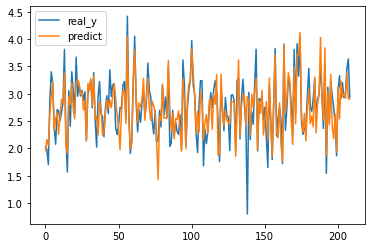

In [34]:
# 繪製 Training loss 和 Validation loss
plt.plot(range(len(y_test)), y_test, label='real_y')
plt.plot(range(len(XGB_predict)), XGB_predict, label='predict')
plt.legend(loc='best')
plt.show()

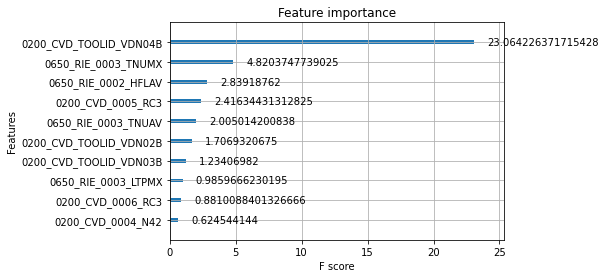

In [35]:
from xgboost import plot_importance
plot_importance(XGB,importance_type= 'gain',max_num_features=10)
plt.show()

# lasso & Ridge & ElasticNet

In [57]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
lasso.fit(X_train, y_train)
lasso_R2 = lasso.score(X_test, y_test)
lasso_R2

0.7585494805328243

In [58]:
lasso_predict = lasso.predict(X_test)
OOS_count(lasso_predict)

'oos_count:44 Total_count:206 Acurracy:0.786'

In [59]:
lasso_MAE = round(mean_absolute_error(y_test,lasso_predict),3)
lasso_MSE = round(mean_squared_error(y_test,lasso_predict),3)
lasso_MAPE = round(MAPE(y_test,lasso_predict),3)
lasso_mean = (abs(lasso_predict - y_test).mean() / y_test.mean() ) *100
lasso_max = ( abs(lasso_predict - y_test).max() / y_test.mean() ) * 100
lasso_min = ( abs(lasso_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{lasso_MAE}\nMSE:{lasso_MSE}\nMAPE:{lasso_MAPE}\nRF_mean:{lasso_mean:.4f}%\nRF_max:{lasso_max:.4f}%\nRF_min:{lasso_min:.4f}%')

MAE:0.19
MSE:0.068
MAPE:7.288
RF_mean:6.8326%
RF_max:34.9482%
RF_min:0.0624%


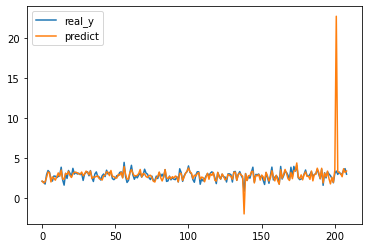

In [39]:
# 繪製 Training loss 和 Validation loss
plt.plot(range(len(y_test)), y_test, label='real_y')
plt.plot(range(len(lasso_predict)), lasso_predict, label='predict')
plt.legend(loc='best')
plt.show()

In [40]:
from sklearn.linear_model import Ridge

In [41]:
Ridge = Ridge(alpha=0.0005,max_iter=10000)
Ridge.fit(X_train, y_train)
Ridge_R2 = Ridge.score(X_test, y_test)
Ridge_R2

-254.13177346747554

In [42]:
Ridge_predict = Ridge.predict(X_test)
OOS_count(Ridge_predict)

'oos_count:2 Total_count:209 Acurracy:0.99'

In [43]:
Ridge_MAE = round(mean_absolute_error(y_test,Ridge_predict),3)
Ridge_MSE = round(mean_squared_error(y_test,Ridge_predict),3)
Ridge_MAPE = round(MAPE(y_test,Ridge_predict),3)
Ridge_mean = (abs(Ridge_predict - y_test).mean() / y_test.mean() ) *100
Ridge_max = ( abs(Ridge_predict - y_test).max() / y_test.mean() ) * 100
Ridge_min = ( abs(Ridge_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{Ridge_MAE}\nMSE:{Ridge_MSE}\nMAPE:{Ridge_MAPE}\nRF_mean:{Ridge_mean:.4f}%\nRF_max:{Ridge_max:.4f}%\nRF_min:{Ridge_min:.4f}%')

MAE:1.031
MSE:74.939
MAPE:53.953
RF_mean:37.3000%
RF_max:4200.2443%
RF_min:0.0347%


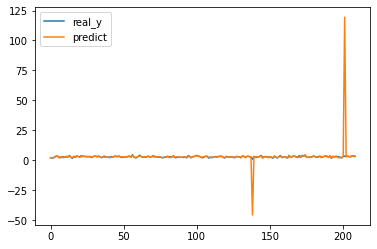

In [44]:
# 繪製 Training loss 和 Validation loss
plt.plot(range(len(y_test)), y_test, label='real_y')
plt.plot(range(len(Ridge_predict)), Ridge_predict, label='predict')
plt.legend(loc='best')
plt.show()

In [45]:
from sklearn.linear_model import ElasticNet
ElasticNet = ElasticNet(alpha=0.0005,max_iter=10000)
ElasticNet.fit(X_train, y_train)
ElasticNet_R2 = ElasticNet.score(X_test, y_test)
ElasticNet_R2

-6.153805634343618

In [46]:
ElasticNet_predict = ElasticNet.predict(X_test)
OOS_count(ElasticNet_predict)

'oos_count:2 Total_count:209 Acurracy:0.99'

In [47]:
ElasticNet_MAE = round(mean_absolute_error(y_test,ElasticNet_predict),3)
ElasticNet_MSE = round(mean_squared_error(y_test,ElasticNet_predict),3)
ElasticNet_MAPE = round(MAPE(y_test,ElasticNet_predict),3)
ElasticNet_mean = (abs(ElasticNet_predict - y_test).mean() / y_test.mean() ) *100
ElasticNet_max = ( abs(ElasticNet_predict - y_test).max() / y_test.mean() ) * 100
ElasticNet_min = ( abs(ElasticNet_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{ElasticNet_MAE}\nMSE:{ElasticNet_MSE}\nMAPE:{ElasticNet_MAPE}\nRF_mean:{ElasticNet_mean:.4f}%\nRF_max:{ElasticNet_max:.4f}%\nRF_min:{ElasticNet_min:.4f}%')

MAE:0.347
MSE:2.101
MAPE:13.44
RF_mean:12.5563%
RF_max:735.6193%
RF_min:0.0446%


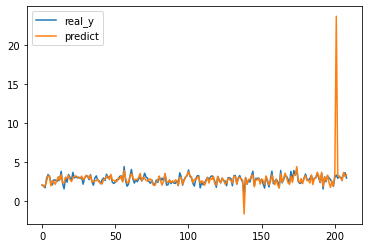

In [48]:
# 繪製 Training loss 和 Validation loss
plt.plot(range(len(y_test)), y_test, label='real_y')
plt.plot(range(len(ElasticNet_predict)), ElasticNet_predict, label='predict')
plt.legend(loc='best')
plt.show()

# SVR

In [49]:
svr = SVR()
svr.fit(X_train,y_train)
svr_R2 = svr.score(X_test, y_test)
svr_R2

0.610696435623798

In [50]:
svr_predict = svr.predict(X_test)
OOS_count(svr_predict)

'oos_count:1 Total_count:209 Acurracy:0.995'

In [51]:
svr_MAE = round(mean_absolute_error(y_test,svr_predict),3)
svr_MSE = round(mean_squared_error(y_test,svr_predict),3)
svr_MAPE = round(MAPE(y_test,svr_predict),3)
svr_mean = (abs(svr_predict - y_test).mean() / y_test.mean() ) *100
svr_max = ( abs(svr_predict - y_test).max() / y_test.mean() ) * 100
svr_min = ( abs(svr_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{svr_MAE}\nMSE:{svr_MSE}\nMAPE:{svr_MAPE}\nRF_mean:{svr_mean:.4f}%\nRF_max:{svr_max:.4f}%\nRF_min:{svr_min:.4f}%')

MAE:0.243
MSE:0.114
MAPE:10.358
RF_mean:8.8048%
RF_max:81.8858%
RF_min:0.0185%


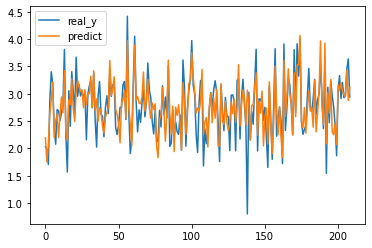

In [52]:
# 繪製 Training loss 和 Validation loss
plt.plot(range(len(y_test)), y_test, label='real_y')
plt.plot(range(len(svr_predict)), svr_predict, label='predict')
plt.legend(loc='best')
plt.show()

# DecisionTree

In [53]:
DecisionTree = DecisionTreeRegressor()
DecisionTree.fit(X_train,y_train)
DecisionTree_R2 = DecisionTree.score(X_test, y_test)
DecisionTree_R2

0.4069986051117922

In [54]:
DecisionTree_predict = DecisionTree.predict(X_test)
OOS_count(DecisionTree_predict)

'oos_count:1 Total_count:209 Acurracy:0.995'

In [55]:
DecisionTree_MAE = round(mean_absolute_error(y_test,DecisionTree_predict),3)
DecisionTree_MSE = round(mean_squared_error(y_test,DecisionTree_predict),3)
DecisionTree_MAPE = round(MAPE(y_test,DecisionTree_predict),3)
DecisionTree_mean = (abs(DecisionTree_predict - y_test).mean() / y_test.mean() ) *100
DecisionTree_max = ( abs(DecisionTree_predict - y_test).max() / y_test.mean() ) * 100
DecisionTree_min = ( abs(DecisionTree_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{DecisionTree_MAE}\nMSE:{DecisionTree_MSE}\nMAPE:{DecisionTree_MAPE}\nRF_mean:{DecisionTree_mean:.4f}%\nRF_max:{DecisionTree_max:.4f}%\nRF_min:{DecisionTree_min:.4f}%')

MAE:0.302
MSE:0.174
MAPE:12.458
RF_mean:10.9309%
RF_max:81.2974%
RF_min:0.0547%


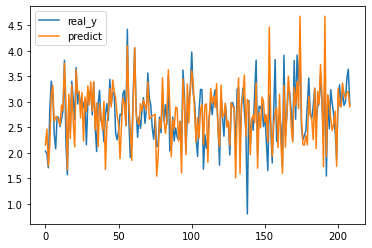

In [56]:
# 繪製 Training loss 和 Validation loss
plt.plot(range(len(y_test)), y_test, label='real_y')
plt.plot(range(len(DecisionTree_predict)), DecisionTree_predict, label='predict')
plt.legend(loc='best')
plt.show()

# RF

In [57]:
RF = RandomForestRegressor()
RF.fit(X_train,y_train)
RF.score(X_test, y_test)

0.6098294424013313

In [58]:
RF_predict = RF.predict(X_test)
OOS_count(RF_predict)

'oos_count:1 Total_count:209 Acurracy:0.995'

In [59]:
RF_MAE = round(mean_absolute_error(y_test,RF_predict),3)
RF_MSE = round(mean_squared_error(y_test,RF_predict),3)
RF_MAPE = round(MAPE(y_test,RF_predict),3)
RF_mean = (abs(RF_predict - y_test).mean() / y_test.mean() ) *100
RF_max = ( abs(RF_predict - y_test).max() / y_test.mean() ) * 100
RF_min = ( abs(RF_predict - y_test).min() / y_test.mean() ) *100
print(f'MAE:{RF_MAE}\nMSE:{RF_MSE}\nMAPE:{RF_MAPE}\nRF_mean:{RF_mean:.4f}%\nRF_max:{RF_max:.4f}%\nRF_min:{RF_min:.4f}%')

MAE:0.251
MSE:0.115
MAPE:10.207
RF_mean:9.0753%
RF_max:68.2656%
RF_min:0.0781%


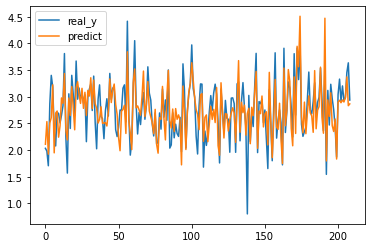

In [60]:
# 繪製 Training loss 和 Validation loss
plt.plot(range(len(y_test)), y_test, label='real_y')
plt.plot(range(len(RF_predict)), RF_predict, label='predict')
plt.legend(loc='best')
plt.show()

In [61]:
# from catboost import CatBoostRegressor
# Cat = CatBoostRegressor()
# Cat.fit(X_train,y_train)
# Cat.score(X_test, y_test)

In [62]:
#RF_value = pd.DataFRame([RF_MAE,RF_MSE,RF_MAPE,RF_mean,RF_max,RF_min])
#model = ['Ridge','Ridge','elastic','Decission tree','RF','XGB','SVR']

In [63]:
column = ['MAE','MSE','MAPE','deviation % mean','deviation % max','deviation % min']
#lasso
model = ['lasso']
lasso_value = [lasso_MAE,lasso_MSE,lasso_MAPE,lasso_mean,lasso_max,lasso_min]
lasso = pd.DataFrame(lasso_value,index=column,columns=model)
#Ridge
model = ['Ridge']
Ridge_value = [Ridge_MAE,Ridge_MSE,Ridge_MAPE,Ridge_mean,Ridge_max,Ridge_min]
Ridge = pd.DataFrame(Ridge_value,index=column,columns=model)
#ElasticNet
model = ['ElasticNet']
ElasticNet_value = [ElasticNet_MAE,ElasticNet_MSE,ElasticNet_MAPE,ElasticNet_mean,ElasticNet_max,ElasticNet_min]
ElasticNet = pd.DataFrame(ElasticNet_value,index=column,columns=model)
#DecisionTree
model = ['DecisionTree']
DecisionTree_value = [DecisionTree_MAE,DecisionTree_MSE,DecisionTree_MAPE,DecisionTree_mean,DecisionTree_max,DecisionTree_min]
DecisionTree = pd.DataFrame(DecisionTree_value,index=column,columns=model)
#RF
model = ['RF']
RF_value = [RF_MAE,RF_MSE,RF_MAPE,RF_mean,RF_max,RF_min]
RF = pd.DataFrame(RF_value,index=column,columns=model)
#XGB
model = ['XGB']
XGB_value = [XGB_MAE,XGB_MSE,XGB_MAPE,XGB_mean,XGB_max,XGB_min]
XGB = pd.DataFrame(XGB_value,index=column,columns=model)
#svr
model = ['svr']
svr_value = [svr_MAE,svr_MSE,svr_MAPE,svr_mean,svr_max,svr_min]
svr = pd.DataFrame(svr_value,index=column,columns=model)

In [64]:
result = pd.concat([lasso,Ridge,ElasticNet,DecisionTree,RF,XGB,svr],axis=1)
result

lasso        Ridge  ElasticNet  DecisionTree  \
MAE                 0.340000     1.031000    0.347000      0.302000   
MSE                 1.929000    74.939000    2.101000      0.174000   
MAPE               13.403000    53.953000   13.440000     12.458000   
deviation % mean   12.316507    37.299979   12.556261     10.930903   
deviation % max   701.574172  4200.244256  735.619255     81.297435   
deviation % min     0.010575     0.034732    0.044553      0.054690   

                         RF        XGB        svr  
MAE                0.251000   0.224000   0.243000  
MSE                0.115000   0.102000   0.114000  
MAPE              10.207000   9.339000  10.358000  
deviation % mean   9.075339   8.113471   8.804764  
deviation % max   68.265636  77.563658  81.885769  
deviation % min    0.078117   0.042712   0.018489